In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import style
style.use('ggplot')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams['font.sans-serif'] = ['Simhei']

import re
import jieba.posseg as psg
import itertools
#conda install -c anaconda gensim
from gensim import corpora,models

# pip install wordcloud
from wordcloud import WordCloud,ImageColorGenerator
from collections import Counter

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import graphviz

In [2]:
raw_data=pd.read_csv('./middle.csv')
raw_data.head()


,机型,IMEI,日期,类别,描述
0,S12 Pro,5b379ba1f97d1552b6217b2af25aee04,2022-01-02,内置程序,用户来电表示自己昨天买了手机让其加了200块钱购买屏保，其表示自己在当地问都是没有屏保，其提...
1,S12 Pro,0c3a8e6c478b93f50c1334013f5f9d7e,2022-01-04,内置程序,用户在手机官网app--我的--S12新机权益--S12代言人专属主题--i主题页面，提示页...
2,S12 Pro,9ff71b338b004d9d098aa993a46341bc,2022-01-05,内置程序,1月3日于河北秦皇岛海港区秦皇岛商城商场金源经销商处（预留号码：155***5711）购买S...
3,S12 Pro,8b83b9485c9d635f7797cfe6770ee424,2022-01-08,内置程序,用户官网买的手机1月3日收到货，现在装入联通+电信两张卡使用中发现设置成上网卡的就会显示5G...
4,S12 Pro,fc911bf2c109ed809024aa5847379b7c,2022-01-11,续航赛道,机器出现待机耗电快，要求换机，其表示昨天已经在售后（山东省青岛市李沧区，具体不详）检测，售后...


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104715 entries, 0 to 104714
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   机型      104715 non-null  object
 1   IMEI    104715 non-null  object
 2   日期      104715 non-null  object
 3   类别      104715 non-null  object
 4   描述      104642 non-null  object
dtypes: object(5)
memory usage: 4.0+ MB


In [4]:
raw_data.columns

Index(['机型', 'IMEI', '日期', '类别', '描述'], dtype='object')

In [5]:
reviews=raw_data[['类别','描述']]
print('去重之前：',reviews.shape[0])
reviews=reviews.drop_duplicates()
print('去重之后：',reviews.shape[0])

去重之前： 104715
去重之后： 97007


In [6]:
reviews.head()

,类别,描述
0,内置程序,用户来电表示自己昨天买了手机让其加了200块钱购买屏保，其表示自己在当地问都是没有屏保，其提...
1,内置程序,用户在手机官网app--我的--S12新机权益--S12代言人专属主题--i主题页面，提示页...
2,内置程序,1月3日于河北秦皇岛海港区秦皇岛商城商场金源经销商处（预留号码：155***5711）购买S...
3,内置程序,用户官网买的手机1月3日收到货，现在装入联通+电信两张卡使用中发现设置成上网卡的就会显示5G...
4,续航赛道,机器出现待机耗电快，要求换机，其表示昨天已经在售后（山东省青岛市李沧区，具体不详）检测，售后...


In [7]:
# 数据清洗
info = re.compile('([0-9a-zA-Z]|_x0000_|手机|华为|机器|用户|服务)')
reviews['描述'] = reviews['描述'].apply(lambda x: info.sub('', str(x)))
reviews['类别'] = reviews['类别'].apply(lambda x: info.sub('', str(x)))

In [8]:
reviews.head()

,类别,描述
0,内置程序,来电表示自己昨天买了让其加了块钱购买屏保，其表示自己在当地问都是没有屏保，其提供了条码帮其查...
1,内置程序,在官网--我的--新机权益--代言人专属主题--主题页面，提示页面被偷走了，换了网络，不同时...
2,内置程序,月日于河北秦皇岛海港区秦皇岛商城商场金源经销商处（预留号码：***）购买，销售人员告知其元旦...
3,内置程序,官网买的月日收到货，现在装入联通+电信两张卡使用中发现设置成上网卡的就会显示，另一张就不显示...
4,续航赛道,出现待机耗电快，要求换机，其表示昨天已经在售后（山东省青岛市李沧区，具体不详）检测，售后告知...


In [9]:
#分词，由元组组成的list
content=reviews['描述']
seg_content=content.apply( lambda s:  [(x.word,x.flag) for x in psg.cut(s)] )  

seg_content.shape
len(seg_content)
print(seg_content[5])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\FOREST\AppData\Local\Temp\jieba.cache
Loading model cost 0.623 seconds.
Prefix dict has been built successfully.


(97007,)

97007

[('*', 'x'), ('*', 'x'), ('*', 'x'), (';', 'x'), ('中文', 'nz'), ('句号', 'n'), (';', 'x'), ('拍照片', 'n'), ('怎么', 'r'), ('调', 'v'), (';', 'x'), ('如何', 'r'), ('开启', 'v'), ('万', 'm'), ('拍摄', 'v'), (';', 'x'), ('如何', 'r'), ('设置', 'vn'), ('万', 'm'), ('像素', 'n'), ('拍摄', 'v'), (';', 'x'), ('如何', 'r'), ('开启', 'v'), ('美颜', 'nr'), (';', 'x'), ('如何', 'r'), ('开启', 'v'), ('侧', 'v'), ('脸', 'n'), ('美颜', 'nr'), (';', 'x'), ('如何', 'r'), ('开启', 'v'), ('儿童', 'n'), ('美颜', 'nr'), (';', 'x'), ('关闭', 'v'), ('万', 'm'), ('拍摄', 'v')]


In [10]:
#统计评论词数
n_word=seg_content.apply(lambda s: len(s))

len(n_word)
n_word.head(6)

97007

0    74
1    36
2    54
3    85
4    45
5    40
Name: 描述, dtype: int64

In [11]:
#得到各分词在第几条评论
n_content=[ [x+1]*y for x,y in zip(list(seg_content.index),list(n_word))]
index_content_long=sum(n_content,[])
len(index_content_long)

3416005

In [12]:
sum([[2,2],[3,3,3]],[])
#分词及词性，去掉[]，拉平
seg_content.head()

seg_content_long=sum(seg_content,[])

seg_content_long

type(seg_content_long)
len(seg_content_long)

[2, 2, 3, 3, 3]

0    [(来电, v), (表示, v), (自己, r), (昨天, t), (买, v), (...
1    [(在, p), (官网, n), (-, x), (-, x), (我, r), (的, ...
2    [(月, m), (日, m), (于, p), (河北, ns), (秦皇岛, nr), ...
3    [(官网, n), (买, v), (的, uj), (月, m), (日, m), (收到...
4    [(出现, v), (待机, n), (耗电, v), (快, a), (，, x), (要...
Name: 描述, dtype: object

[('来电', 'v'),
 ('表示', 'v'),
 ('自己', 'r'),
 ('昨天', 't'),
 ('买', 'v'),
 ('了', 'ul'),
 ('让', 'v'),
 ('其', 'r'),
 ('加', 'v'),
 ('了', 'ul'),
 ('块钱', 'n'),
 ('购买', 'v'),
 ('屏保', 'nz'),
 ('，', 'x'),
 ('其', 'r'),
 ('表示', 'v'),
 ('自己', 'r'),
 ('在', 'p'),
 ('当地', 's'),
 ('问', 'v'),
 ('都', 'd'),
 ('是', 'v'),
 ('没有', 'v'),
 ('屏保', 'nz'),
 ('，', 'x'),
 ('其', 'r'),
 ('提供', 'v'),
 ('了', 'ul'),
 ('条码', 'n'),
 ('帮', 'v'),
 ('其', 'r'),
 ('查询', 'v'),
 ('购买', 'v'),
 ('的', 'uj'),
 ('不是', 'c'),
 ('官方', 'n'),
 ('碎', 'a'),
 ('屏保', 'nz'),
 ('，', 'x'),
 ('询问', 'v'),
 ('其', 'r'),
 ('是不是', 'l'),
 ('购买', 'v'),
 ('的', 'uj'),
 ('第三方', 'm'),
 ('的', 'uj'),
 ('其', 'r'),
 ('不', 'd'),
 ('知道', 'v'),
 ('，', 'x'),
 ('其', 'r'),
 ('表示', 'v'),
 ('购买', 'v'),
 ('点', 'm'),
 ('说', 'v'),
 ('的', 'uj'),
 ('全国', 'n'),
 ('每', 'zg'),
 ('一个', 'm'),
 ('官方', 'n'),
 ('售后', 'n'),
 ('中心', 'n'),
 ('都', 'd'),
 ('能', 'v'),
 ('使用', 'v'),
 ('。', 'x'),
 ('购买', 'v'),
 ('点', 'm'),
 ('：', 'x'),
 ('河南省', 'ns'),
 ('郑州市', 'ns'),
 ('二七', 'm'),
 ('迪信通', 'n

list

3416005

In [13]:
seg_content_long[0]

('来电', 'v')

In [14]:
#得到加长版的分词、词性
word_long=[x[0] for x in seg_content_long]
nature_long=[x[1] for x in seg_content_long]

len(word_long)
len(nature_long)

3416005

3416005

In [15]:
#content_type拉长
n_content_type=[ [x]*y for x,y in zip(list(reviews['类别']),list(n_word))]
content_type_long=sum(n_content_type,[])

len(content_type_long)

3416005

In [16]:
review_long=pd.DataFrame({'index_content':index_content_long,
                        'word':word_long,
                        'nature':nature_long,
                        'content_type':content_type_long})
review_long.shape
review_long.head()

(3416005, 4)

,index_content,word,nature,content_type
0,1,来电,v,内置程序
1,1,表示,v,内置程序
2,1,自己,r,内置程序
3,1,昨天,t,内置程序
4,1,买,v,内置程序


In [17]:
review_long['nature'].unique()

array(['v', 'r', 't', 'ul', 'n', 'nz', 'x', 'p', 's', 'd', 'uj', 'c', 'a',
       'l', 'm', 'zg', 'ns', 'nr', 'nt', 'vn', 'q', 'f', 'b', 'tg', 'u',
       'ad', 'rr', 'ng', 'nrt', 'ug', 'i', 'vg', 'e', 'z', 'vq', 'an',
       'yg', 'df', 'nrfg', 'y', 'uz', 'mq', 'o', 'j', 'ud', 'h', 'k',
       'vd', 'g', 'uv', 'mg', 'ag', 'vi', 'rg', 'rz', 'dg'], dtype=object)

In [18]:
#去除标点符号
review_long_clean=review_long[review_long['nature']!='x']
review_long_clean.shape

(2606710, 4)

In [19]:
#导入停用词
stop_path=open('./stoplist.txt','r',encoding='UTF-8')
stop_words=stop_path.readlines()

len(stop_words)
stop_words[0:5]

5748

['\ufeff \n', '说\n', '人\n', '元\n', 'hellip\n']

In [20]:
#停用词
stop_words=[word.strip('\n') for word in stop_words]
stop_words[0:5]

['\ufeff ', '说', '人', '元', 'hellip']

In [21]:
#得到不含停用词的分词表
word_long_clean=list(set(word_long)-set(stop_words))
len(word_long_clean)

review_long_clean=review_long_clean[review_long_clean['word'].isin(word_long_clean)]
review_long_clean.shape

51469

(1351346, 4)

In [22]:
#再次统计每条评论的分词数量
n_word=review_long_clean.groupby('index_content').count()['word']
n_word

index_word=[ list(np.arange(1,x+1)) for x in list(n_word)] 
index_word_long=sum(index_word,[])

len(index_word_long)

index_content
1         32
2         16
3         34
4         43
5         18
          ..
104711     4
104712     5
104713    30
104714     5
104715     6
Name: word, Length: 96734, dtype: int64

1351346

In [23]:
review_long_clean['index_word']=index_word_long
review_long_clean.head()

,index_content,word,nature,content_type,index_word
0,1,来电,v,内置程序,1
3,1,昨天,t,内置程序,2
8,1,加,v,内置程序,3
10,1,块钱,n,内置程序,4
11,1,购买,v,内置程序,5


In [24]:
review_long_clean.to_csv('./1_review_long_clean.csv')

In [25]:
n_review_long_clean=review_long_clean[[ 'n' in nat for nat in review_long_clean.nature]]
n_review_long_clean.shape
n_review_long_clean.head()

(633176, 5)

,index_content,word,nature,content_type,index_word
10,1,块钱,n,内置程序,4
12,1,屏保,nz,内置程序,6
23,1,屏保,nz,内置程序,8
28,1,条码,n,内置程序,10
35,1,官方,n,内置程序,14


In [26]:
n_review_long_clean.nature.value_counts()
n_review_long_clean.to_csv('./1_n_review_long_clean.csv')

n       492556
vn       50632
nr       34607
ns       22889
nz       14752
ng        8181
nrt       6676
an        1835
nt         787
nrfg       261
Name: nature, dtype: int64

<Figure size 2000x1000 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

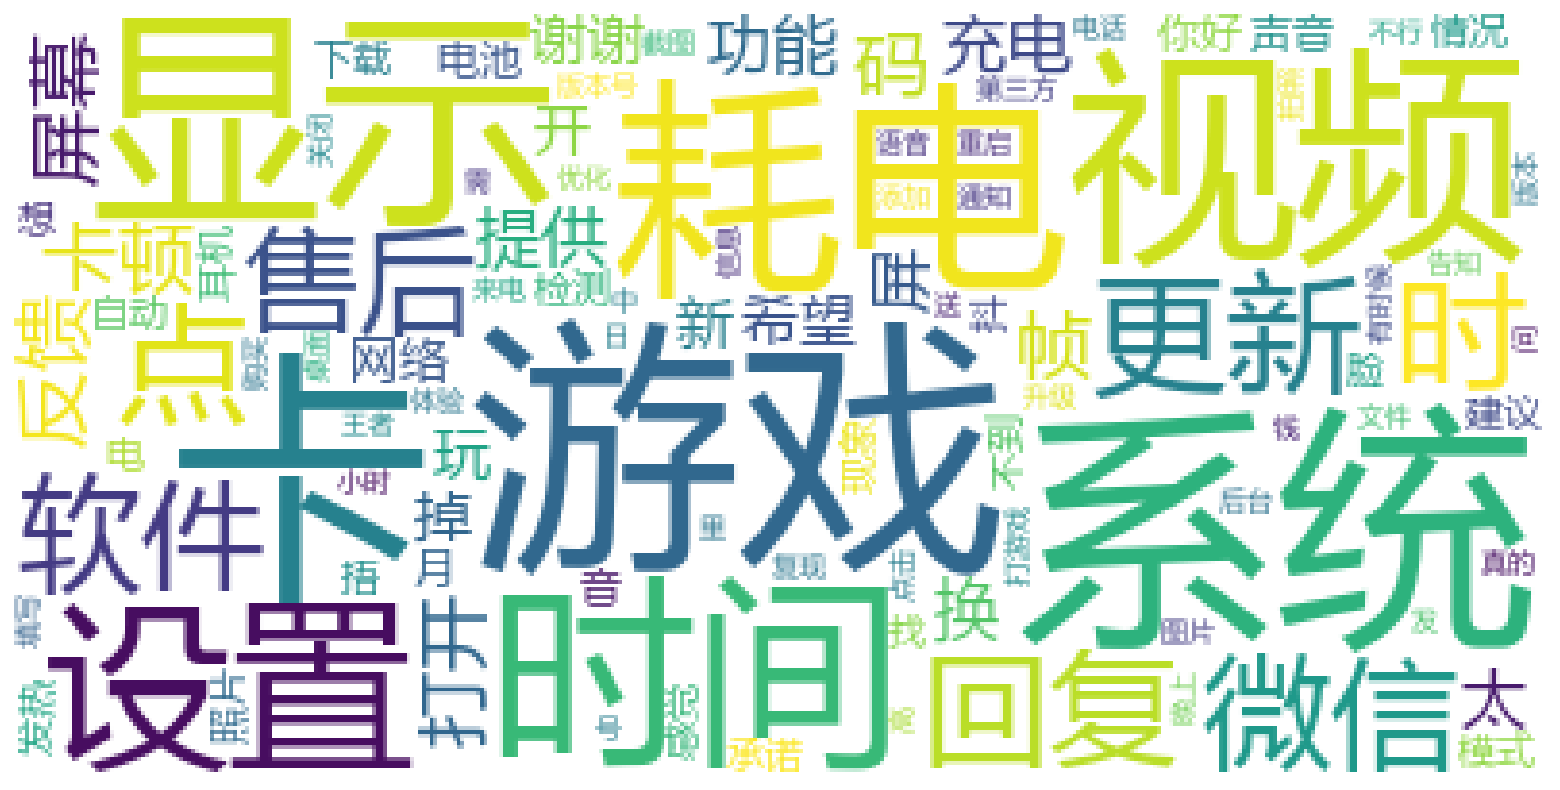

In [27]:
font=r"C:\Windows\Fonts\msyh.ttc"

wordcloud = WordCloud(font_path=font, max_words = 100, background_color='white') #width=1600,height=1200, mode='RGBA'
wordcloud.generate_from_frequencies(Counter(review_long_clean.word.values))
wordcloud.to_file('1_分词后的词云图.png')

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Figure size 2000x1000 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

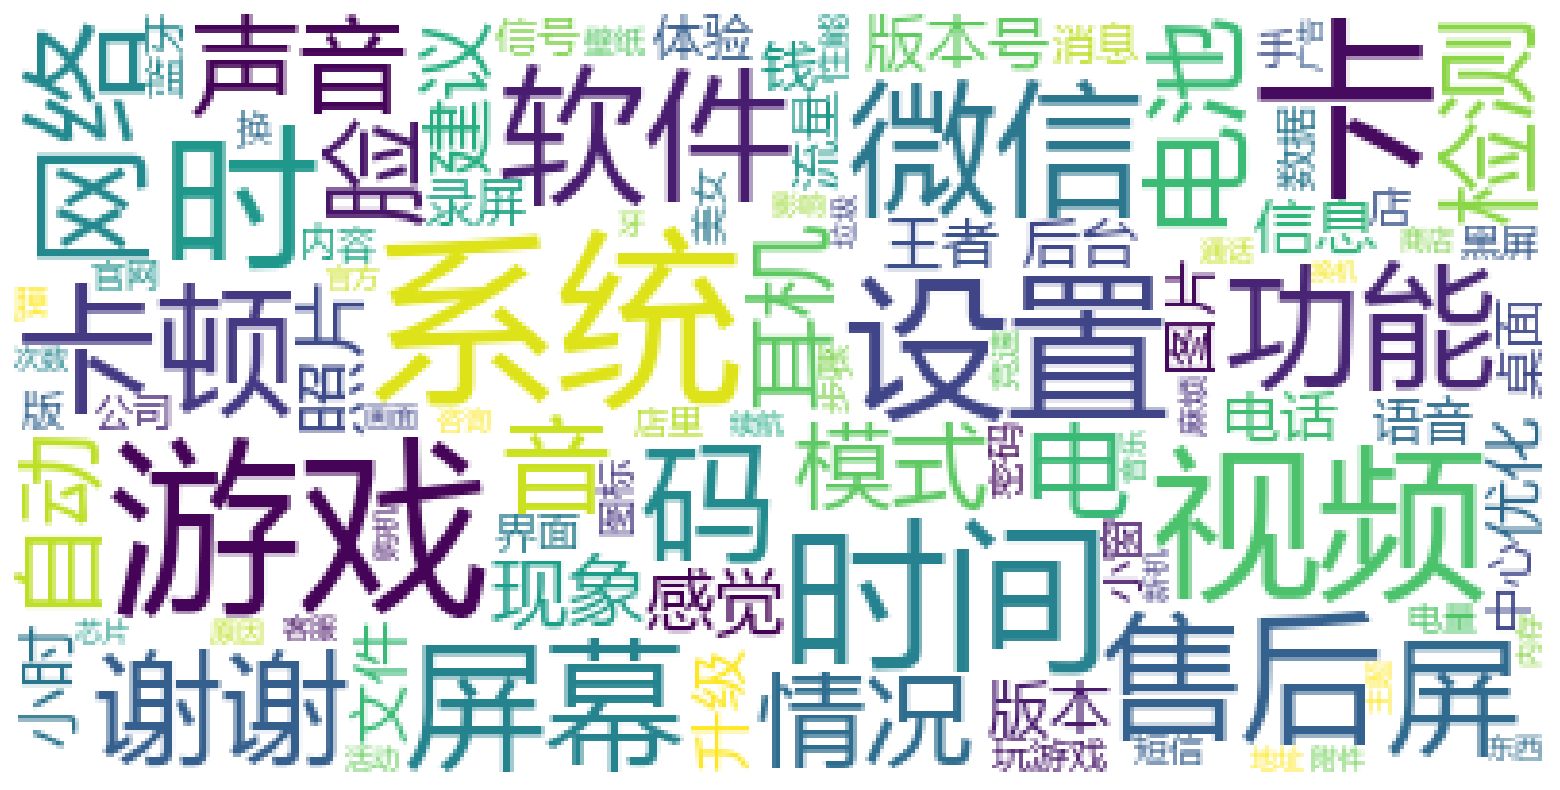

In [28]:
font=r"C:\Windows\Fonts\msyh.ttc"

wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white') #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(n_review_long_clean.word.values))
wordcloud.to_file('1_分词后的词云图(名词）.png')

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [29]:
#情感分析
#来自知网发布的情感分析用词语集

pos_comment=pd.read_csv('./正面评价词语（中文）.csv',header=None,encoding='utf-8') 
neg_comment=pd.read_csv('./负面评价词语（中文）.csv',header=None,encoding='utf-8')

pos_emotion=pd.read_csv('./正面情感词语（中文）.csv',header=None,encoding='utf-8')
neg_emotion=pd.read_csv('./负面情感词语（中文）.csv',header=None,encoding='utf-8')

In [30]:
pos_comment.shape
neg_comment.shape

pos_emotion.shape
neg_emotion.shape

(3743, 1)

(3138, 1)

(833, 1)

(1251, 1)

In [31]:
#合并情感/评价表
pos=pd.concat([pos_comment,pos_emotion],axis=0)
pos.shape
pos.head()
neg=pd.concat([neg_comment,neg_emotion],axis=0)
neg.shape
pos.head()

(4576, 1)

,0
0,侻
1,俶傥
2,僄
3,劼
4,嫕


(4389, 1)

,0
0,侻
1,俶傥
2,僄
3,劼
4,嫕


In [32]:
#根据案例特点增加新词
#判断新词是否在原表中
c='点赞'
c in pos.values

d='歇菜'
d in neg.values

False

False

In [33]:
#添加新词到表中
new_pos=pd.Series(['点赞'])
new_neg=pd.Series(['歇菜'])
positive=pd.concat([pos,new_pos],axis=0)
positive.shape

negative=pd.concat([neg,new_neg],axis=0)
negative.shape

(4577, 1)

(4390, 1)

In [34]:
positive.columns=['review']
positive['weight']=pd.Series([1]*len(positive))
positive.head()

,review,weight
0,侻,1
1,俶傥,1
2,僄,1
3,劼,1
4,嫕,1


In [35]:
negative.columns=['review']
negative['weight']=pd.Series([-1]*len(negative))
negative.head()

,review,weight
0,僄,-1
1,啰啰唆唆,-1
2,啰啰嗦嗦,-1
3,啰里啰唆,-1
4,啰里啰嗦,-1


In [36]:
pos_neg=pd.concat([positive,negative],axis=0)
pos_neg.shape
pos_neg.head()

(8967, 2)

,review,weight
0,侻,1
1,俶傥,1
2,僄,1
3,劼,1
4,嫕,1


In [37]:
data=review_long_clean.copy()
review_mltype=pd.merge(data,pos_neg,how='left',left_on='word',right_on='review')
review_mltype.shape

review_mltype=review_mltype.drop(['review'],axis=1)
review_mltype=review_mltype.replace(np.nan,0)
review_mltype.head()

(1351346, 7)

,index_content,word,nature,content_type,index_word,weight
0,1,来电,v,内置程序,1,0.0
1,1,昨天,t,内置程序,2,0.0
2,1,加,v,内置程序,3,0.0
3,1,块钱,n,内置程序,4,0.0
4,1,购买,v,内置程序,5,0.0


In [38]:
notdict=pd.read_csv('./not.csv')
notdict.shape

notdict['freq']=[1]*len(notdict)
notdict.head()

(21, 1)

,term,freq
0,不,1
1,没,1
2,无,1
3,非,1
4,莫,1


In [39]:
review_mltype['amend_weight']=review_mltype['weight']
review_mltype['id']=np.arange(0,review_mltype.shape[0])
review_mltype.head()

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,1,来电,v,内置程序,1,0.0,0.0,0
1,1,昨天,t,内置程序,2,0.0,0.0,1
2,1,加,v,内置程序,3,0.0,0.0,2
3,1,块钱,n,内置程序,4,0.0,0.0,3
4,1,购买,v,内置程序,5,0.0,0.0,4


In [40]:
# 只保留有情感值的行

only_review_mltype=review_mltype[review_mltype['weight']!=0]
only_review_mltype.index=np.arange(0,only_review_mltype.shape[0]) #索引重置
only_review_mltype.shape
only_review_mltype.head()

(15795, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,15,慢,a,内置程序,8,-1.0,-1.0,490
1,21,不好,d,内置程序,5,-1.0,-1.0,734
2,33,不好,d,续航赛道,22,-1.0,-1.0,1119
3,36,不好,d,发热赛道,42,-1.0,-1.0,1208
4,36,不好,d,发热赛道,44,-1.0,-1.0,1210


In [41]:
i=4
review_i=review_mltype[review_mltype['index_content']==only_review_mltype['index_content'][i]]
review_i

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
1167,36,耗电,v,发热赛道,1,0.0,0.0,1167
1168,36,充,v,发热赛道,2,0.0,0.0,1168
1169,36,玩,v,发热赛道,3,0.0,0.0,1169
1170,36,小时,n,发热赛道,4,0.0,0.0,1170
1171,36,发热,v,发热赛道,5,0.0,0.0,1171
1172,36,拍照,v,发热赛道,6,0.0,0.0,1172
1173,36,偏暗,d,发热赛道,7,0.0,0.0,1173
1174,36,发红,v,发热赛道,8,0.0,0.0,1174
1175,36,浙江省,ns,发热赛道,9,0.0,0.0,1175
1176,36,宁波市,ns,发热赛道,10,0.0,0.0,1176


In [42]:
#看该情感词前2个词，来判罚否定的语气。如果在句首，则没有否词，如果在句子的第二次词，则看前1个词，来判断否定的语气。

index=only_review_mltype['id']

for i in range(0,only_review_mltype.shape[0]):
    
    review_i=review_mltype[review_mltype['index_content']==only_review_mltype['index_content'][i]]
    review_i.index=np.arange(0,review_i.shape[0])
    word_ind = only_review_mltype['index_word'][i]
    
    if word_ind==2:
        ne=sum( [ review_i['word'][word_ind-1] in notdict['term']  ] )
        if ne==1:
            review_mltype['amend_weight'][index[i]] = -( review_mltype['weight'][index[i]] )      
    elif word_ind > 2:
        ne=sum( [ word in notdict['term'] for word in review_i['word'][[word_ind-1,word_ind-2]]  ] ) 
        if ne==1:
            review_mltype['amend_weight'][index[i]]=- ( review_mltype['weight'][index[i]] )

In [43]:
review_mltype.shape
review_mltype[(review_mltype['weight']-review_mltype['amend_weight'])!=0] 

(1351346, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,id


In [44]:
review_mltype.tail()

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
1351341,104715,游戏,n,外观设计,2,0.0,0.0,1351341
1351342,104715,选,v,外观设计,3,0.0,0.0,1351342
1351343,104715,手感,n,外观设计,4,0.0,0.0,1351343
1351344,104715,丝滑,n,外观设计,5,0.0,0.0,1351344
1351345,104715,完美,a,外观设计,6,1.0,1.0,1351345


In [45]:
emotion_value=review_mltype.groupby('index_content',as_index=False)['amend_weight'].sum()
emotion_value.head()
emotion_value.to_csv('./1_emotion_value',index=True,header=True)

,index_content,amend_weight
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [46]:
#每条评论的amend_weight总和不等于零

content_emotion_value=emotion_value.copy()
content_emotion_value.shape
content_emotion_value=content_emotion_value[content_emotion_value['amend_weight']!=0]
content_emotion_value['ml_type']=''
content_emotion_value['ml_type'][content_emotion_value['amend_weight']>0]='pos'
content_emotion_value['ml_type'][content_emotion_value['amend_weight']<0]='neg'

content_emotion_value.shape
content_emotion_value.head()

(96734, 2)

C:\Users\FOREST\AppData\Local\Temp\ipykernel_14084\2363425304.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_emotion_value['ml_type'][content_emotion_value['amend_weight']>0]='pos'
C:\Users\FOREST\AppData\Local\Temp\ipykernel_14084\2363425304.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_emotion_value['ml_type'][content_emotion_value['amend_weight']<0]='neg'


(11229, 3)

,index_content,amend_weight,ml_type
14,15,-1.0,neg
20,21,-1.0,neg
32,33,-1.0,neg
35,36,-2.0,neg
37,38,-1.0,neg


In [47]:
#每条评论的amend_weight总和等于零
content_emotion_value0=emotion_value.copy()
content_emotion_value0=content_emotion_value0[content_emotion_value0['amend_weight']==0]
content_emotion_value0.head()


,index_content,amend_weight
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [48]:
#合并到大表中
content_emotion_value.columns
content_emotion_value=content_emotion_value.drop(['amend_weight'],axis=1)
review_mltype.shape
review_mltype=pd.merge(review_mltype,content_emotion_value,how='left',left_on='index_content',right_on='index_content')
review_mltype.columns
review_mltype=review_mltype.drop(['id'],axis=1)
review_mltype.shape
review_mltype.head()

review_mltype.to_csv('./1_review_mltype',index=True,header=True)

Index(['index_content', 'amend_weight', 'ml_type'], dtype='object')

(1351346, 8)

Index(['index_content', 'word', 'nature', 'content_type', 'index_word',
       'weight', 'amend_weight', 'id', 'ml_type'],
      dtype='object')

(1351346, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,ml_type
0,1,来电,v,内置程序,1,0.0,0.0,NaN
1,1,昨天,t,内置程序,2,0.0,0.0,NaN
2,1,加,v,内置程序,3,0.0,0.0,NaN
3,1,块钱,n,内置程序,4,0.0,0.0,NaN
4,1,购买,v,内置程序,5,0.0,0.0,NaN


In [66]:
cate=['index_content','content_type','ml_type']
data_type=review_mltype[cate].drop_duplicates()

confusion_matrix=pd.crosstab(data_type['content_type'],data_type['ml_type'],margins=True)
confusion_matrix['neg/All'] = confusion_matrix.apply(lambda x: x['neg']/x['All'], axis=1)
confusion_matrix.sort_values('neg/All', ascending=False, inplace=True)
confusion_matrix = confusion_matrix[confusion_matrix['All'] > 100]
confusion_matrix

ml_type,neg,pos,All,neg/All
content_type,,,,
系统流畅性,102,35,137,0.744526
第三方程序,89,32,121,0.735537
性能赛道,2869,1087,3956,0.725228
外观体验,102,44,146,0.698630
发热赛道,620,282,902,0.687361
触控,105,52,157,0.668790
All,7150,4079,11229,0.636744
续航赛道,806,539,1345,0.599257
内置程序,1729,1453,3182,0.543369


In [50]:
data=review_mltype.copy()
data=data[data['amend_weight']!=0]

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']

<Figure size 1500x700 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

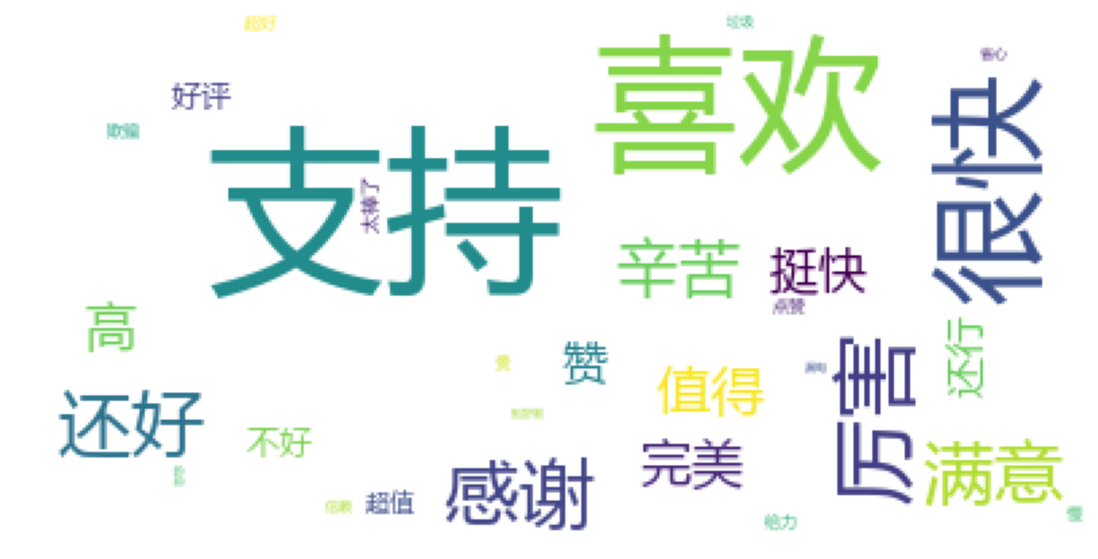

In [51]:
font=r"C:\Windows\Fonts\msyh.ttc"


wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white')
wordcloud.generate_from_frequencies(Counter(word_data_pos.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Figure size 1500x700 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

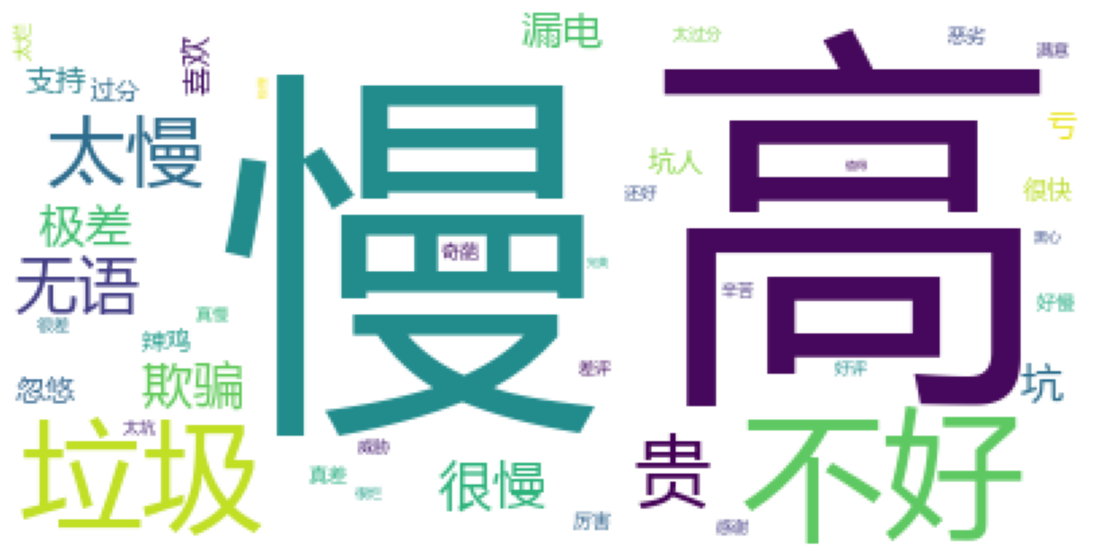

In [52]:
font=r"C:\Windows\Fonts\msyh.ttc"


wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white')
wordcloud.generate_from_frequencies(Counter(word_data_neg.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Figure size 1500x700 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

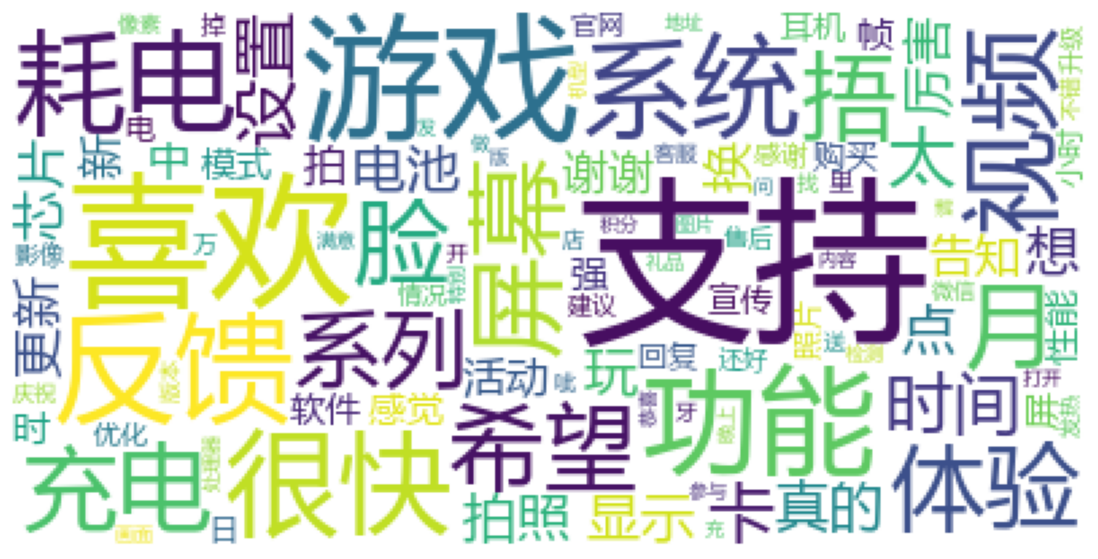

<Figure size 1500x700 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

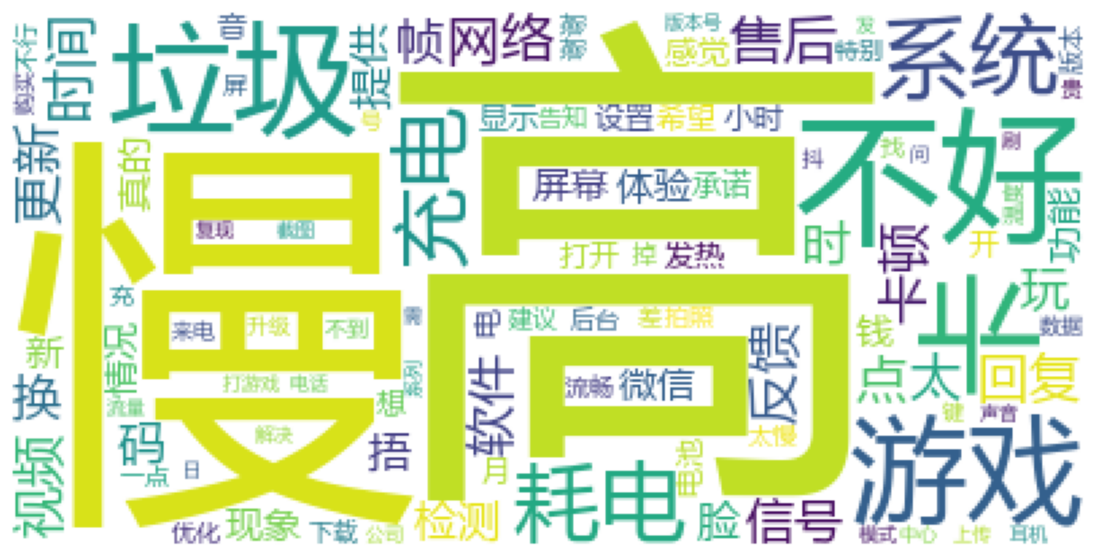

In [53]:
data=review_mltype.copy()

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']

font=r"C:\Windows\Fonts\msyh.ttc"


wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white') #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_pos.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white') #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_neg.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [54]:
#LDA
data=review_mltype.copy()

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']

In [55]:
#建立词典，去重

pos_dict=corpora.Dictionary([ [i] for i in word_data_pos.word]) #shape=(n,1)
neg_dict=corpora.Dictionary([ [i] for i in word_data_neg.word])

In [56]:
print(pos_dict)

Dictionary(17247 unique tokens: ['弄', '猜', '人物', '明星', '闹钟']...)


In [57]:
#建立语料库

pos_corpus=[ pos_dict.doc2bow(j) for j in [ [i] for i in word_data_pos.word] ] 
neg_corpus=[ neg_dict.doc2bow(j) for j in [ [i] for i in word_data_neg.word] ]

In [58]:
len(word_data_pos.word)
len(pos_dict)
len(pos_corpus)
pos_corpus 

145266

17247

145266

[[(0, 1)],
 [(1, 1)],
 [(2, 1)],
 [(3, 1)],
 [(4, 1)],
 [(5, 1)],
 [(6, 1)],
 [(7, 1)],
 [(8, 1)],
 [(9, 1)],
 [(10, 1)],
 [(11, 1)],
 [(12, 1)],
 [(9, 1)],
 [(13, 1)],
 [(14, 1)],
 [(9, 1)],
 [(15, 1)],
 [(16, 1)],
 [(14, 1)],
 [(9, 1)],
 [(17, 1)],
 [(18, 1)],
 [(12, 1)],
 [(19, 1)],
 [(20, 1)],
 [(21, 1)],
 [(22, 1)],
 [(23, 1)],
 [(24, 1)],
 [(25, 1)],
 [(26, 1)],
 [(27, 1)],
 [(28, 1)],
 [(29, 1)],
 [(30, 1)],
 [(31, 1)],
 [(32, 1)],
 [(23, 1)],
 [(25, 1)],
 [(26, 1)],
 [(22, 1)],
 [(33, 1)],
 [(34, 1)],
 [(35, 1)],
 [(36, 1)],
 [(37, 1)],
 [(38, 1)],
 [(39, 1)],
 [(40, 1)],
 [(41, 1)],
 [(42, 1)],
 [(43, 1)],
 [(44, 1)],
 [(45, 1)],
 [(46, 1)],
 [(47, 1)],
 [(48, 1)],
 [(45, 1)],
 [(46, 1)],
 [(49, 1)],
 [(50, 1)],
 [(51, 1)],
 [(45, 1)],
 [(46, 1)],
 [(52, 1)],
 [(53, 1)],
 [(54, 1)],
 [(45, 1)],
 [(46, 1)],
 [(55, 1)],
 [(53, 1)],
 [(45, 1)],
 [(46, 1)],
 [(50, 1)],
 [(56, 1)],
 [(57, 1)],
 [(58, 1)],
 [(9, 1)],
 [(59, 1)],
 [(60, 1)],
 [(61, 1)],
 [(58, 1)],
 [(62, 1)],
 [(63,

In [59]:
#构造主题数寻优函数

def cos(vector1,vector2):
    dot_product=0.0
    normA=0.0
    normB=0.0
    for a,b in zip(vector1,vector2):
        dot_product +=a*b
        normA +=a**2
        normB +=b**2
    if normA==0.0 or normB==0.0:
        return None
    else:
        return ( dot_product/((normA*normB)**0.5) )

In [60]:
#主题数寻优
#这个函数可以重复调用，解决其他项目的问题

def LDA_k(x_corpus,x_dict):
    #初始化平均余玄相似度
    mean_similarity=[]
    mean_similarity.append(1)
    
    #循环生成主题并计算主题间相似度
    for i in np.arange(2,11):
        lda=models.LdaModel(x_corpus,num_topics=i,id2word=x_dict) #LDA模型训练
        
        for j in np.arange(i):
            term=lda.show_topics(num_words=50)
        
        #提取各主题词
        top_word=[] #shape=(i,50)
        for k in np.arange(i):
            top_word.append( [''.join(re.findall('"(.*)"',i)) for i in term[k][1].split('+')]) #列出所有词
        
        #构造词频向量
        word=sum(top_word,[]) #列车所有词
        unique_word=set(word) #去重
        
        #构造主题词列表，行表示主题号，列表示各主题词
        mat=[] #shape=(i,len(unique_word))
        for j in np.arange(i):
            top_w=top_word[j]
            mat.append( tuple([ top_w.count(k) for k in unique_word ])) #统计list中元素的频次，返回元组
        
        #两两组合。方法一
        p=list(itertools.permutations(list(np.arange(i)),2)) #返回可迭代对象的所有数学全排列方式。
        y=len(p) # y=i*(i-1)
        top_similarity=[0]
        for w in np.arange(y):
            vector1=mat[p[w][0]]
            vector2=mat[p[w][1]]
            top_similarity.append(cos(vector1,vector2))

            
        #计算平均余玄相似度
        mean_similarity.append(sum(top_similarity)/ y)
    return mean_similarity

In [61]:
#计算主题平均余玄相似度

pos_k=LDA_k(pos_corpus,pos_dict)
neg_k=LDA_k(neg_corpus,neg_dict)

pos_k
neg_k

[1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

[1, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

<AxesSubplot:>

Text(0.5, 1.0, '正面评论LDA主题数寻优')

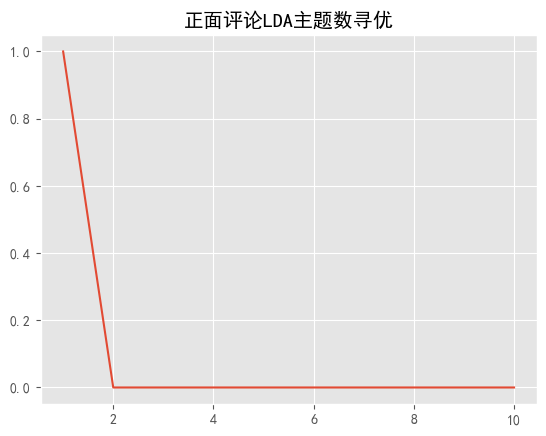

In [62]:
pd.Series(pos_k,index=range(1,11)).plot()
plt.title('正面评论LDA主题数寻优')
plt.show()

<AxesSubplot:>

Text(0.5, 1.0, '负面评论LDA主题数寻优')

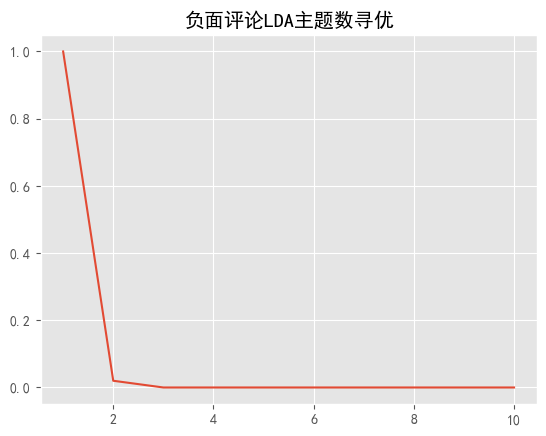

In [63]:
pd.Series(neg_k,index=range(1,11)).plot()
plt.title('负面评论LDA主题数寻优')
plt.show()

In [64]:
pos_lda=models.LdaModel(pos_corpus,num_topics=2,id2word=pos_dict)
neg_lda=models.LdaModel(neg_corpus,num_topics=2,id2word=neg_dict)

pos_lda.print_topics(num_topics=10)
neg_lda.print_topics(num_topics=10)

[(0,
  '0.009*"耗电" + 0.008*"影像" + 0.008*"很快" + 0.008*"帧" + 0.007*"告知" + 0.007*"体验" + 0.006*"点" + 0.006*"视频" + 0.006*"虚假" + 0.005*"内容"'),
 (1,
  '0.030*"支持" + 0.020*"反馈" + 0.018*"游戏" + 0.013*"屏幕" + 0.011*"芯片" + 0.010*"宣传" + 0.009*"功能" + 0.009*"耳机" + 0.008*"充电" + 0.008*"系统"')]

[(0,
  '0.024*"高" + 0.020*"垃圾" + 0.017*"慢" + 0.016*"不用" + 0.012*"系统" + 0.012*"帧" + 0.011*"卡" + 0.009*"更新" + 0.009*"截图" + 0.009*"听"'),
 (1,
  '0.027*"不好" + 0.025*"游戏" + 0.015*"拍" + 0.014*"像素" + 0.010*"反馈" + 0.010*"拍照" + 0.009*"耗电" + 0.008*"充电" + 0.008*"网络" + 0.008*"捂"')]